# Visualization

In [1]:
%reload_ext autoreload
%autoreload 3

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import shap
import numpy as np

## SHAP Plots

In [2]:
# open shap data 
with open('data/classification_results/shap_values.pkl', 'rb') as f:
    _shap_values = pickle.load(f)

# sift out shap, y_pred, y_test values
shap_keys = list(_shap_values.keys())[:3]
y_preds_keys = list(_shap_values.keys())[3:6]
y_test_keys = list(_shap_values.keys())[6:9]

shap_values = {k:_shap_values[k] for k in shap_keys}
y_preds = {k[7:]:_shap_values[k] for k in y_preds_keys} # remove 'y_pred_'
y_tests = {k[7:]:_shap_values[k] for k in y_test_keys} # remove 'y_test_'

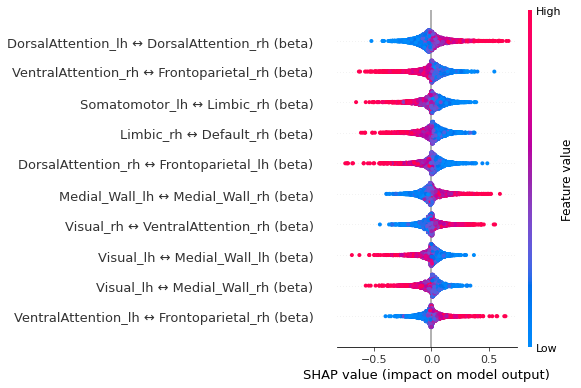

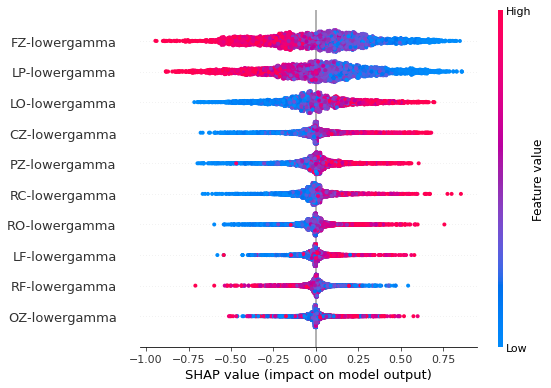

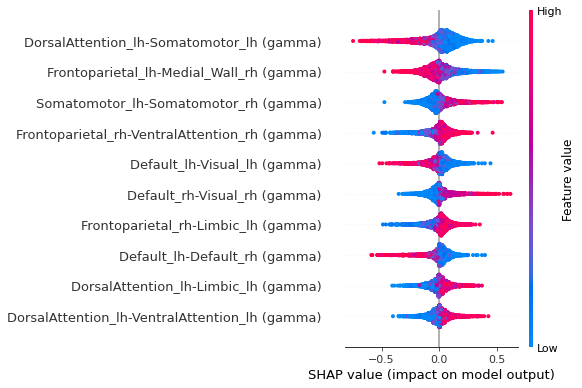

In [4]:
for model_name in shap_values.keys():
    
    shap.summary_plot(shap_values[model_name],  max_display=10)

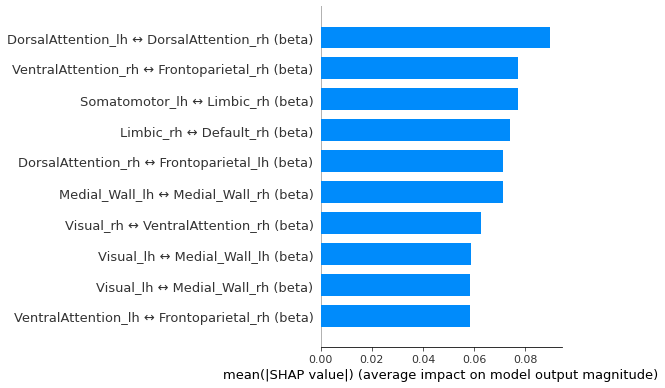

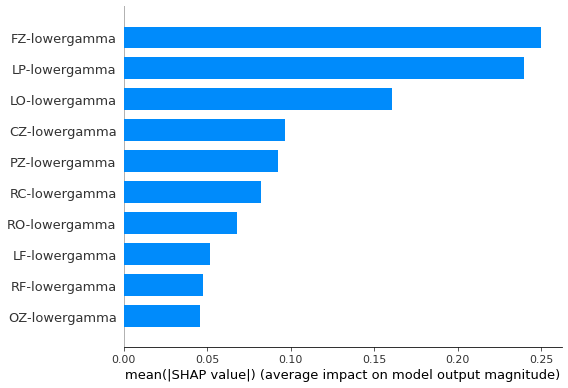

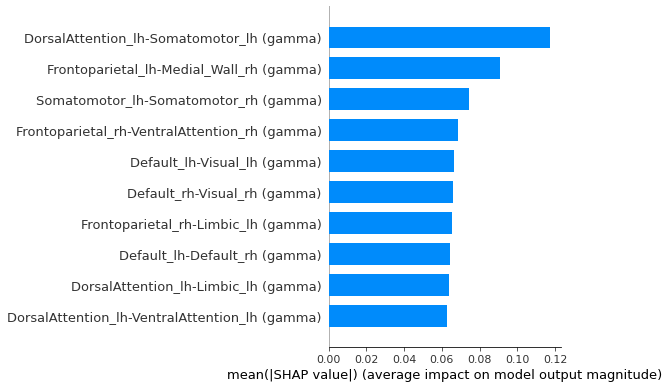

In [5]:
for model_name in shap_values.keys():
    
    shap.summary_plot(shap_values[model_name], plot_type='bar', max_display=10)

In [6]:
# force plot
shap.initjs()

model_name = 'power sensor (gamma)'
i = 3  # participant index

shap.force_plot(shap_values[model_name].base_values[i],
                shap_values[model_name].values[i],
                shap_values[model_name].data[i])

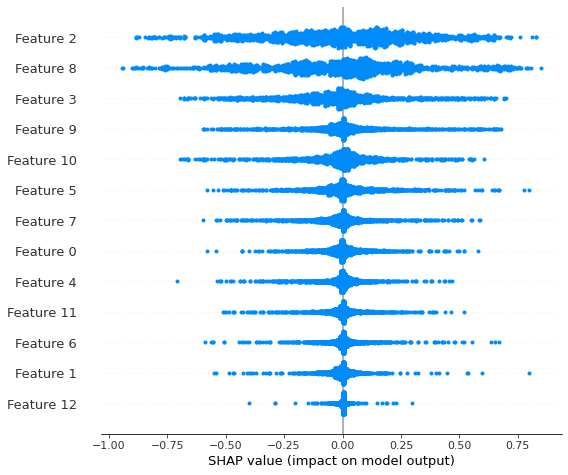

In [6]:
model_name = 'power sensor (gamma)'

misclassified_mask = np.where(y_preds[model_name] != y_tests[model_name])[0]
misclassified_mask_shap = shap_values[model_name].values[misclassified_mask]
shap.summary_plot(misclassified_mask_shap)

## Feature Importance Plots

In [33]:
# open data
with open('data/classification_results/importances.pkl', 'rb') as f:
    importances = pickle.load(f)

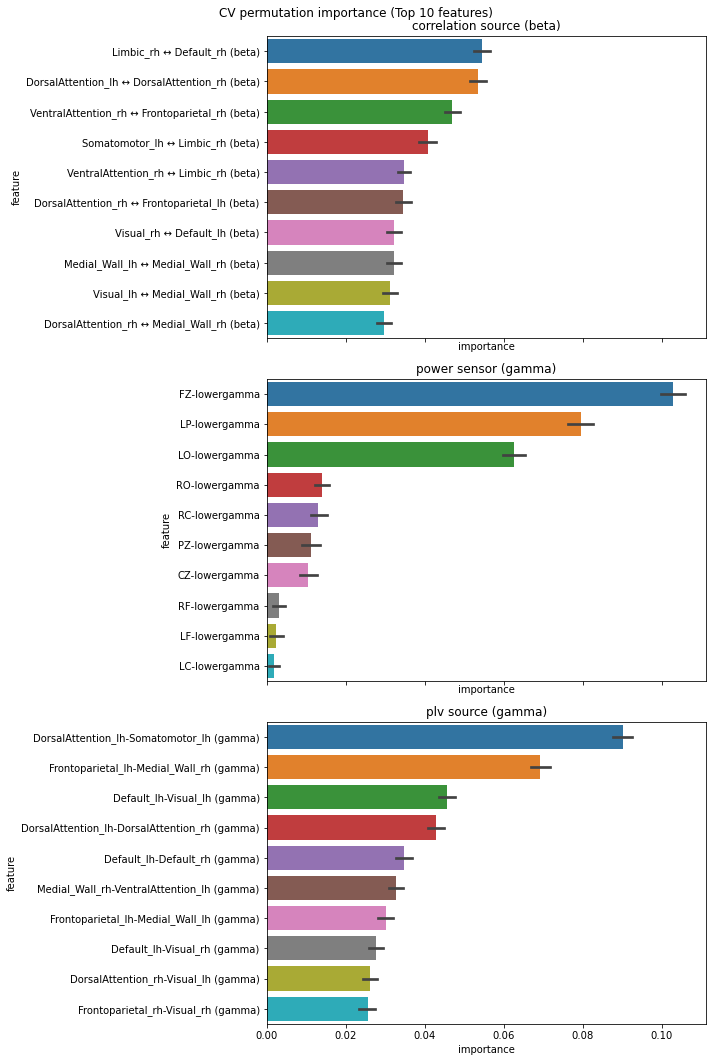

In [34]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 15))

for i, (model_name, model_importances) in enumerate(importances.items()):
    
    order = model_importances.mean(axis=0).sort_values(ascending=False).index
    importances_long = model_importances.melt(var_name='feature', value_name='importance')
    
    sns.barplot(data=importances_long, x='importance', y='feature', order=order[:10], ax=axes[i])
    
    axes[i].set_title(model_name)
plt.suptitle('CV permutation importance (Top 10 features)')
plt.tight_layout()
plt.show()